# MLFLOW setup in Jupyter Notebook

This notebook contains a small Data Science Project where MLFlow is used to log all Feature Engineering and Modeling Parameters as well as Metrics.


We can eventually reply some questions such as
* Why corrosion happens
* Which are important factors in which corrosion occurs?
* Which metals are more corrosion resistant?



## Loading Data

In [183]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import warnings
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import time
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors
# Models making
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,  cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# import of the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error, mean_absolute_error

# XGBoost model
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')
# Specifing figure layout
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (15, 10)

from rich_dataframe import prettify

### Ions in the Testing Solution
Corrosion depends in the type of material and in the enviroment in which the materials are located. The following Dataframe corresponds to the Features that are the material itself in the test solution.

In [184]:
data_all = pd.read_excel("/Users/beatrizamandawatts/neufische/Corrosion_85_prediction/data/Epit.xlsx")
#df = pd.read_csv("/Users/beatrizamandawatts/neufische/Corrosion_85_prediction/data/Corr_Me.csv")#ParserError: Error tokenizing data. C error: Expected 32 fields in line 89, saw 33
    #"data/Corr_Me.xlsx")
data_all.head()

,No.,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,...,Test Solution,[Cl-],pH,Test Method,Scan Rate (mV/s),Heat treatment,Microstructures,Comments,Reference,Material class
0,1,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"300 ppm NaCl, pH 7.8",0.005133,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
1,2,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"500 ppm NaCl, pH 7.8",0.008556,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
2,3,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"1000 ppm NaCl, pH 7.8",0.017112,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
3,4,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"5000 ppm NaCl, pH 7.8",0.085558,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
4,5,69.705,18.0,10.0,NaN,0.0,NaN,0.0,0.03,1.0,...,Seawater Natural,0.546000,8.2,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy


In [185]:
print("Total Observations: {}".format(len(data_all)))

Total Observations: 810


### Enviroment in which Corrosion Occurs
The  Dataframe in notebook 1 corresponds to the Features that make the solution medio in which the corrosion test is made and which facilitate the process. This dataframe was worked independienly on the Notebook "Corr Enviro" for corrosion environment

In [186]:
#Taken only the ions in solution for corrosion prediction as baseline model
Corr_Me= data_all[['No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu', 'P', 'S', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Avg Epit. mV (SCE)', 'Material class']]

In [187]:
#Replacing the name of Avg. Epit. mV(SCE) for Epit, which means the E potential for pitting
Corr_Me.rename(columns={'Avg Epit. mV (SCE)': 'Epit'}, inplace=True)
Corr_Me.rename(columns={'Material class': 'Material'}, inplace=True)

In [188]:
Corr_Me.columns

Index(['No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu',
       'P', 'S', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd',
       'Epit', 'Material'],
      dtype='object')

## Data cleaning

In [189]:
Corr_Me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No.       810 non-null    int64  
 1   Fe        810 non-null    float64
 2   Cr        805 non-null    float64
 3   Ni        788 non-null    float64
 4   Mo        779 non-null    float64
 5   W         795 non-null    float64
 6   N         274 non-null    float64
 7   Nb        772 non-null    float64
 8   C         368 non-null    float64
 9   Si        357 non-null    float64
 10  Mn        329 non-null    float64
 11  Cu        156 non-null    float64
 12  P         189 non-null    float64
 13  S         199 non-null    object 
 14  Al        734 non-null    float64
 15  V         810 non-null    float64
 16  Ta        810 non-null    float64
 17  Re        810 non-null    float64
 18  Ce        810 non-null    float64
 19  Ti        805 non-null    float64
 20  Co        810 non-null    float6

In [190]:
Corr_Me.describe().T.style \
    .format('{:.2f}')

,count,mean,std,min,25%,50%,75%,max
No.,810.00,406.90,235.55,1.00,203.25,405.50,611.75,814.00
Fe,810.00,44.18,31.62,0.00,0.00,57.00,69.46,100.00
Cr,805.00,16.42,9.77,0.00,15.00,18.00,21.48,100.00
Ni,788.00,18.18,23.46,0.00,0.11,10.10,24.60,100.00
Mo,779.00,5.35,13.45,0.00,0.00,1.91,4.53,100.00
W,795.00,0.18,1.48,0.00,0.00,0.00,0.00,27.21
N,274.00,0.14,0.14,0.00,0.03,0.12,0.21,0.69
Nb,772.00,0.41,4.18,0.00,0.00,0.00,0.00,64.96
C,368.00,0.03,0.02,0.00,0.01,0.02,0.03,0.11
Si,357.00,0.71,1.40,0.00,0.22,0.44,0.64,16.00


Transforming data to correct datatype

In [191]:
#there is a string in the number column as <0.003, so I will replace to 0.002
Corr_Me["S"]=Corr_Me.S.replace("<0.003", 0.002)
Corr_Me["Epit"]=Corr_Me["Epit"].replace(">800", 801)
Corr_Me["Epit"]=Corr_Me["Epit"].replace(">1256", 1257)

In [192]:
#there is an unexpected stream in the target value, i will replace it to NAN and then I will drop all rows with NAN in that column
Corr_Me["Epit"].replace("Transpassive", np.nan, inplace=True)
#Now we convert the Target datatype from Object to float
Corr_Me = Corr_Me.astype({"Epit": float})
#Check that the conversion was suscessful
Corr_Me["Epit"].dtypes
#Rounding the values to 2
Corr_Me["Epit"]=Corr_Me.Epit.round(2)

### Corr_Me_f for target free nan

In [193]:
#Drop all the rows of the target that have nan, real data with all target I putthe name _f
Corr_Me_f= Corr_Me.dropna(how="any", subset=["Epit"])
# resetting the DataFrame index
Corr_Me_f= Corr_Me_f.reset_index()
print("Target NaNs : {}".format(Corr_Me_f["Epit"].isna().sum()))
print("Target count : {}".format(Corr_Me_f.Epit.shape[0]))

Target NaNs : 0
Target count : 760


### knowing how much percentage of NaNs there are in every feature column

In [194]:
# We need to know the percentage of NaNs values in every feature column
na_percentage = Corr_Me_f.isna().sum()/Corr_Me_f.shape[0]*100
na_percentage= na_percentage.round(2)


### Percentage of Missing Data from the elemental content
|Fe|0.00|Cr|0.66|Ni|2.89|Mo|4.08|W|1.97|
|-|-|-|-|-|-|-|-|-|-|
|N|65.00|Nb|5.00|C|52.63|Si|54.08|Mn|57.89|
|Cu|79.47|P|75.13|S|73.82|Al|10.00|V|0.00|
|Ta|0.00|Re|0.00|Ce|0.00|Ti|0.66|Co|0.00|
|B|0.00|Mg|0.00|Y|0.00|Gd|1.58|Epit|0.00|

### Corr_Me_fnet for Feature pruning after 60%

In [195]:
# list of columns having more than 60% null
col_to_drop = na_percentage[na_percentage>60].keys()
# Deleting the columns that have too little data
Corr_Me_fnet= Corr_Me_f.drop(col_to_drop, axis=1)
Corr_Me_fnet.columns

Index(['index', 'No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn',
       'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit',
       'Material'],
      dtype='object')

In [196]:
print("Columns droped because >60% NaNs : {}".format([Corr_Me_f.columns.difference(Corr_Me_fnet.columns)]))
print("Elements left for the Corrosion Prediction Analysis: {}".format(Corr_Me_fnet.columns))

Columns droped because >60% NaNs : [Index(['Cu', 'N', 'P', 'S'], dtype='object')]
Elements left for the Corrosion Prediction Analysis: Index(['index', 'No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn',
       'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit',
       'Material'],
      dtype='object')


Elements in solution analysed that have been drop because lack of data are:
Cu, P, S and N. That is too bad because Cu is known to be one of the most utilised metals in water and cooling systems. N, P and S are known to be a potential high attacker of metal.

## Imputing
it is not possible to input values in all the columns with the same calculation because there are different type of metals which concentration of metal depends upon de type of material but also the type of solution that is in the environment of the corrosion. So it is necesary to look similar sistems in order to input values only similar systems.
For that matter, we import the Data that corresponds to the Environment solution on which the test was made which is NOTEBOOK 1

In [197]:
Corr_Finalia = pd.read_csv("../data/Corrosion_Finalia.csv")
Corr_Finalia= Corr_Finalia.drop("Epit", axis=1)
Corr_Finalia.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo',
       'M_Other'],
      dtype='object')

In [198]:
Corr_Me_fnet= Corr_Me_fnet.drop(["No.", "index"], axis=1)
Corr_Me_fnet = Corr_Me_fnet.round(decimals = 2)

In [199]:
#Whole compiled data frame that got deleted
df_AlloysNan=pd.concat([Corr_Finalia, Corr_Me_fnet], axis=1)
df_AlloysNan.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

In [200]:
'''for i in df_AlloysNan:
    if df_AlloysNan["column"]==1:
        df_AlloysNan.interpolate(method="linear")
    else pass'''

'for i in df_AlloysNan:\n    if df_AlloysNan["column"]==1:\n        df_AlloysNan.interpolate(method="linear")\n    else pass'

Make individual dataframes for each Material class or after integrate the dataframes, we could 
slice the df per material class so to interpolate the missing values

In [201]:
Corr_Me_Ma= Corr_Me_fnet.drop("Material", axis=1)

I take out the material column so that i can interpolate each matriz without the string, WHICH IS IN MATERIAL CLASS

In [202]:
#We do each individual material imputation
df_Al_Alloy_nan = pd.concat([Corr_Finalia["M_Al"], Corr_Me_Ma], axis=1)
df_Fe_Alloy_nan = pd.concat([Corr_Finalia["M_Fe"], Corr_Me_Ma], axis=1)
df_HEA_nan = pd.concat([Corr_Finalia["M_HEA"], Corr_Me_Ma], axis=1)
df_NiCrMo_nan = pd.concat([Corr_Finalia["M_NiCrMo"], Corr_Me_Ma], axis=1)
df_Other_nan = pd.concat([Corr_Finalia["M_Other"], Corr_Me_Ma], axis=1)

In [203]:
from sklearn.impute import KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=3, weights="uniform")

Tran_Al=imputer.fit_transform(df_Al_Alloy_nan)
Al_Alloy_nn= pd.DataFrame(Tran_Al)
Al_Alloy_nn.columns= ['M_Al', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit']
#inputation with the interpolation
Al_interp = df_Al_Alloy_nan.interpolate(method="linear")
Al_interp.columns

Index(['M_Al', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V',
       'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

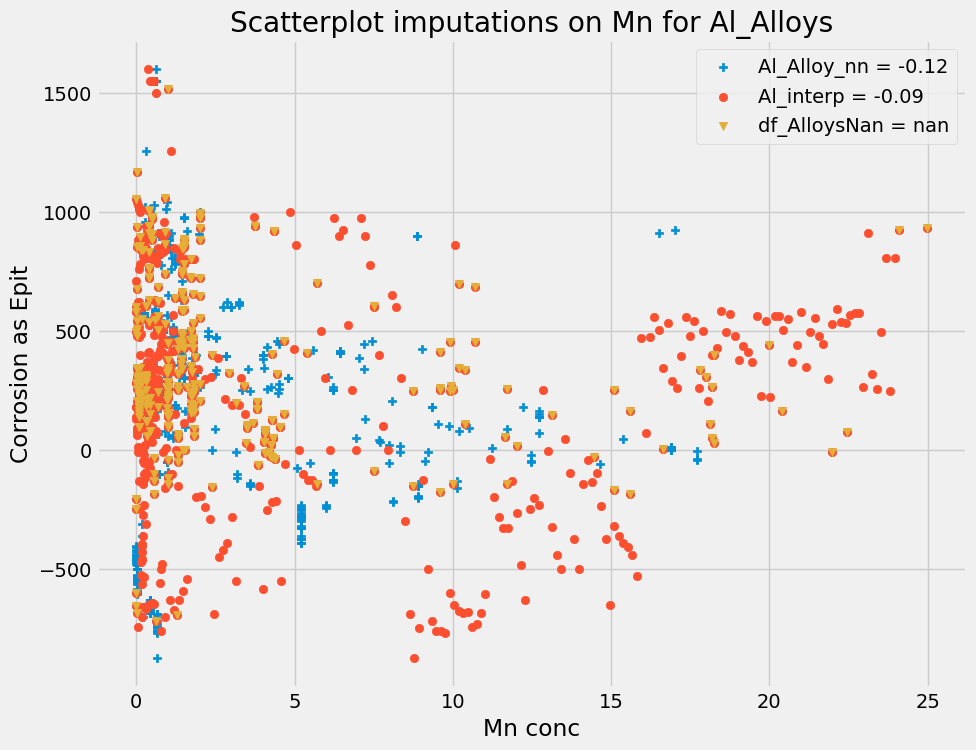

In [204]:
# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

plt.scatter(Al_Alloy_nn.Mn, Al_Alloy_nn.Epit, marker='P',label=f'Al_Alloy_nn = {np.round(np.corrcoef(Al_Alloy_nn.Mn, Al_Alloy_nn.Epit)[0,1], 2)}')
plt.scatter(Al_interp.Mn, Al_interp.Epit, marker='o', label=f'Al_interp = {np.round(np.corrcoef(Al_interp.Mn, Al_interp.Epit)[0,1], 2)}')
plt.scatter(df_AlloysNan.Mn, df_AlloysNan.Epit, marker='v', label=f'df_AlloysNan = {np.round(np.corrcoef(df_AlloysNan.Mn, df_AlloysNan.Epit)[0,1], 2)}')
# Plot
plt.title('Scatterplot imputations on Mn for Al_Alloys')
plt.xlabel('Mn conc')
plt.ylabel('Corrosion as Epit')
plt.legend()
plt.show()

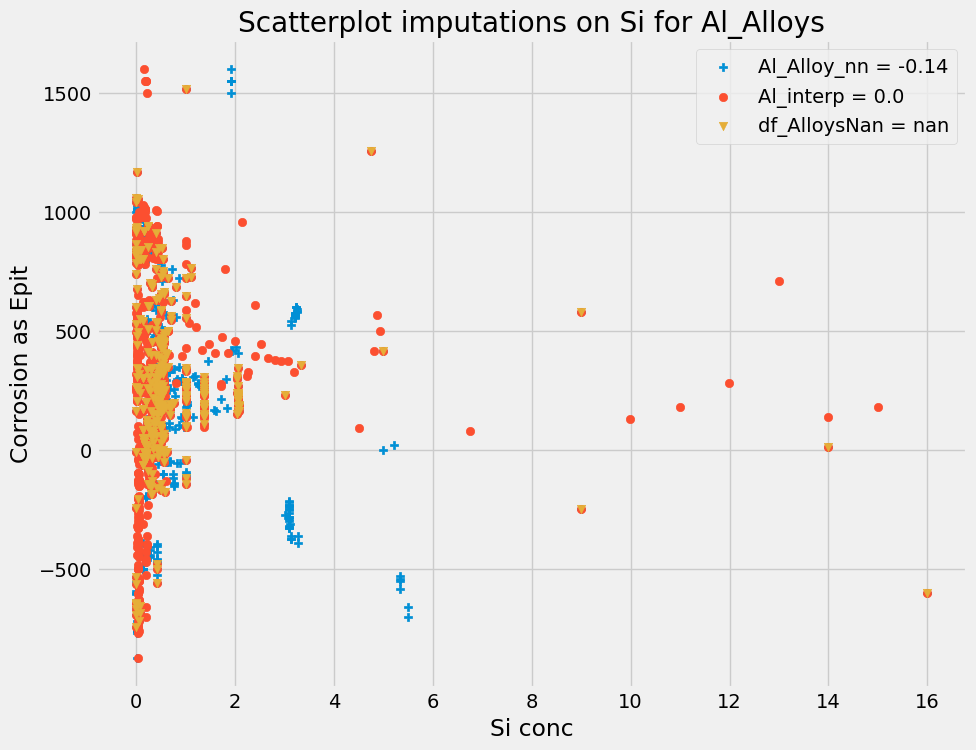

In [205]:
# Plot
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

plt.scatter(Al_Alloy_nn.Si, Al_Alloy_nn.Epit, marker='P',label=f'Al_Alloy_nn = {np.round(np.corrcoef(Al_Alloy_nn.Si, Al_Alloy_nn.Epit)[0,1], 2)}')
plt.scatter(Al_interp.Si, Al_interp.Epit, marker='o', label=f'Al_interp = {np.round(np.corrcoef(Al_interp.Si, Al_interp.Epit)[0,1], 2)}')
plt.scatter(df_AlloysNan.Si, df_AlloysNan.Epit, marker='v', label=f'df_AlloysNan = {np.round(np.corrcoef(df_AlloysNan.Si, df_AlloysNan.Epit)[0,1], 2)}')
# Plot
plt.title('Scatterplot imputations on Si for Al_Alloys')
plt.xlabel('Si conc')
plt.ylabel('Corrosion as Epit')
plt.legend()
plt.show()

Clearly an interpolation just like that is in better agreement with the behaviour of the raw dataset, so I will calculate the other missing data by interpolation and summarise the matrix for modeling. We interpolate the other Alloys Fe, HEA, Others and NiCrMo

In [206]:
#inputation with the interpolation
Fe_imputer = df_Fe_Alloy_nan.interpolate(method="linear")
HEA_imputer = df_HEA_nan.interpolate(method="linear")
NiCrMo_imputer = df_NiCrMo_nan.interpolate(method="linear")
Other_imputer = df_Other_nan.interpolate(method="linear")
Other_imputer.shape

(760, 22)

### Whole Dataframe inputing
Imputing with whole dataframe regardeless of type of material

In [207]:
Corr_Me_Ma.columns

Index(['Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

In [208]:
# To calculate mean use imputer class
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
Corr_Simputer_T = imputer.fit_transform(Corr_Me_Ma)
Corr_Simputer = pd.DataFrame(Corr_Simputer_T)
Corr_Simputer.columns= ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V',
       'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit']
Corr_Simputer.shape

(760, 21)

In [209]:
from sklearn.impute import KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=3, weights="uniform")

Corr_TNN=imputer.fit_transform(Corr_Me_Ma)
Corr_NN= pd.DataFrame(Corr_TNN)
Corr_NN.columns= ['Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit']

In [210]:
#inputation with the interpolation
E_interp = Corr_Me_Ma.interpolate(method="linear")
E_interp.isna().sum()

Fe      0
Cr      0
Ni      0
Mo      5
W       0
Nb      0
C       0
Si      0
Mn      0
Al      0
V       0
Ta      0
Re      0
Ce      0
Ti      0
Co      0
B       0
Mg      0
Y       0
Gd      0
Epit    0
dtype: int64

## :fearful: :scream:
imputing the missing values with ceros, because possible the metals that are missing never existed on those alloys in the first place ;)


In [211]:
df_AlloysNan.head(5)
#df_AlloysNan.isna().sum()

,Cl,Test_Temp,pH,M_Al,M_Fe,M_HEA,M_NiCrMo,M_Other,Fe,Cr,...,Re,Ce,Ti,Co,B,Mg,Y,Gd,Epit,Material
0,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,Fe Alloy
1,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,Fe Alloy
2,0.02,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.0,Fe Alloy
3,0.09,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,Fe Alloy
4,0.55,50.0,8.2,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,Fe Alloy


In [212]:
Alloy_Null  = df_AlloysNan.fillna(0)
#Alloy_Null = Alloy_Null.drop("Material", axis=1)
Alloy_Null.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

In [213]:
#lets concatenate just for plotting
Corr_Simputer_Ma= pd.concat([Corr_Simputer,Corr_Me_fnet["Material"]], axis=1)
Alloy_NN_Ma= pd.concat([Corr_NN, Corr_Me_fnet["Material"]], axis=1)
Alloy_Inter_Ma= pd.concat([E_interp , Corr_Me_fnet["Material"]], axis=1)

In [214]:
#Raw data with medio imputates df_AlloysNan
df_AlloysNan.to_csv("../data/Alloy_Nan.csv", index=False)
#Total_Alloy_Medio replaced Nan with cero
Alloy_Null.to_csv("../data/Alloy_Null.csv", index=False)
#Most sensible imputation I would think
Alloy_Inter_Ma.to_csv("../data/Alloy_Inter_Ma.csv", index=False)
#Nearest Neighbours Imputation
Alloy_NN_Ma.to_csv("../data/Alloy_NN_MA.csv", index=False)


In [215]:
Alloy_NN_Ma.head()
Alloy_NN_Ma.columns

Index(['Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

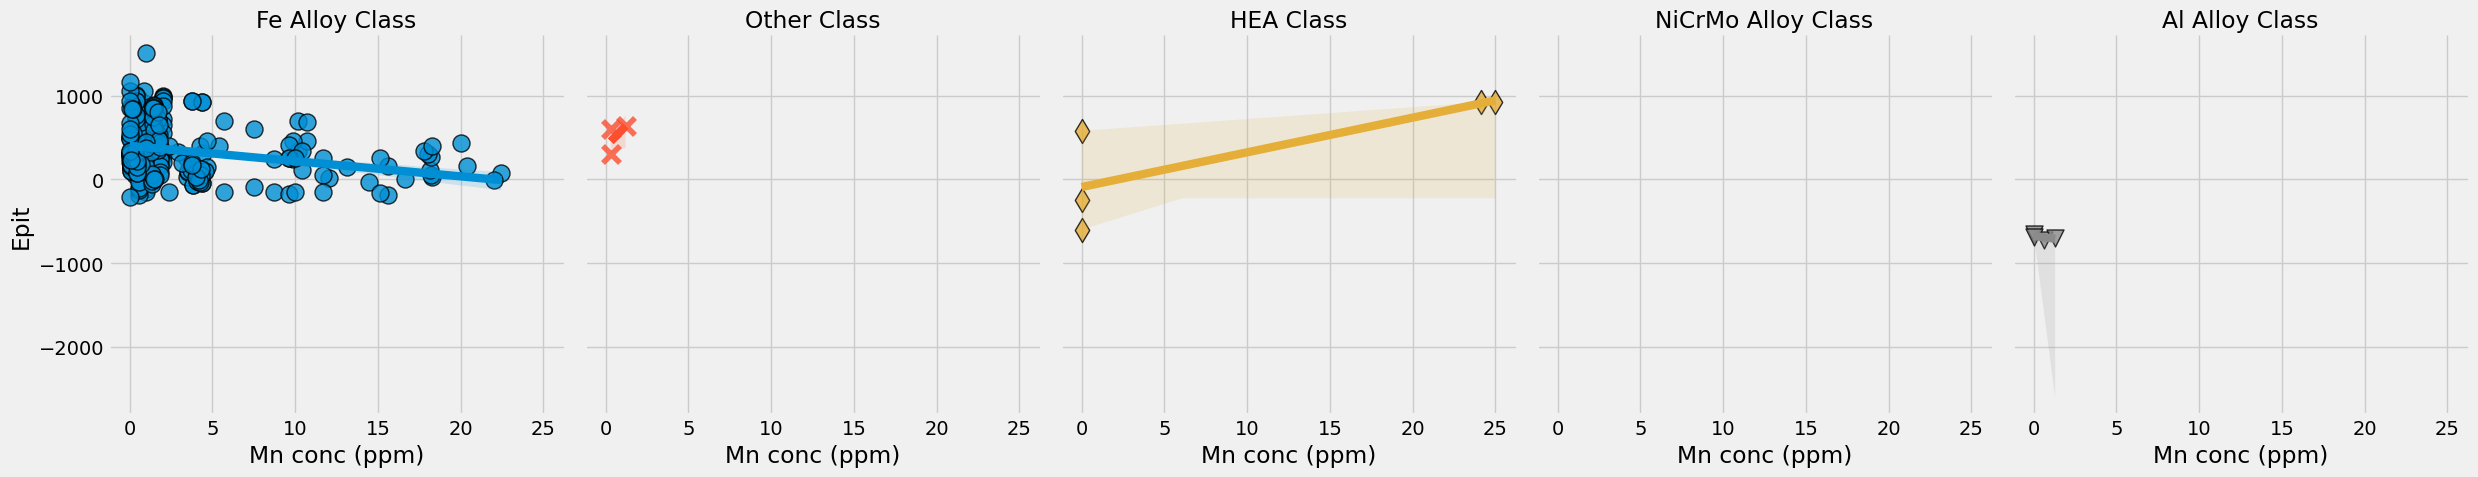

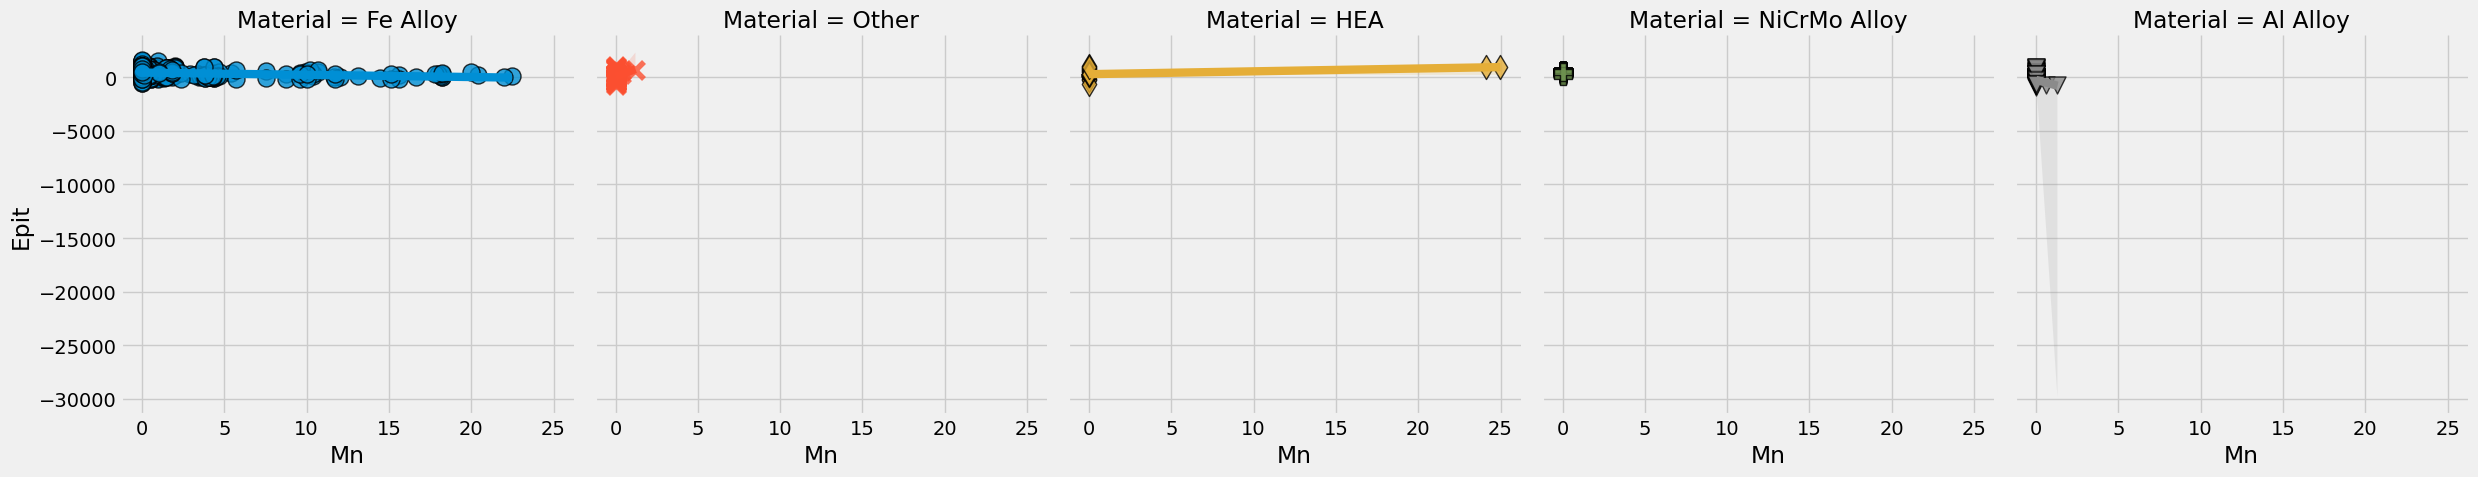

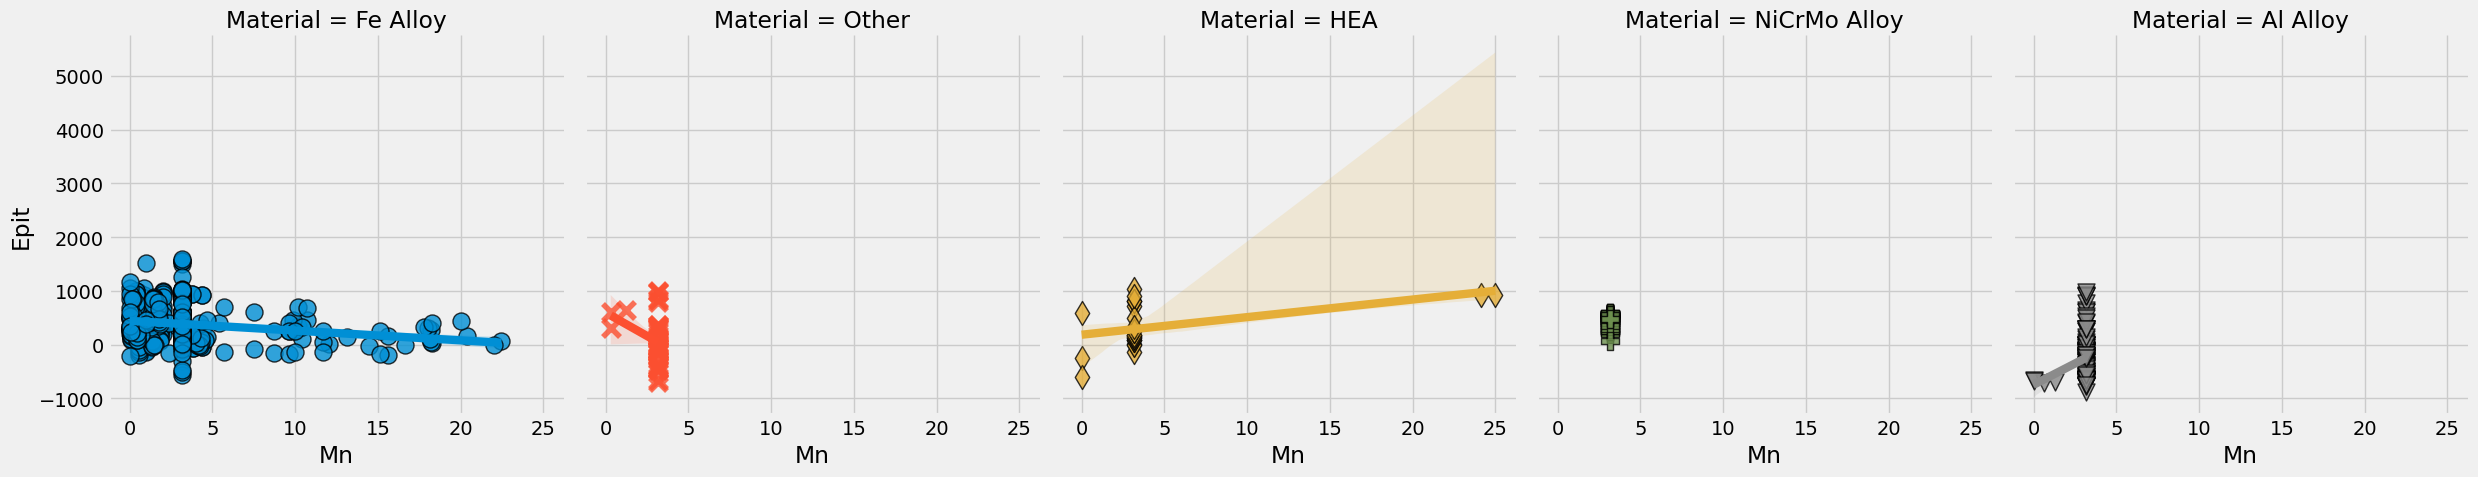

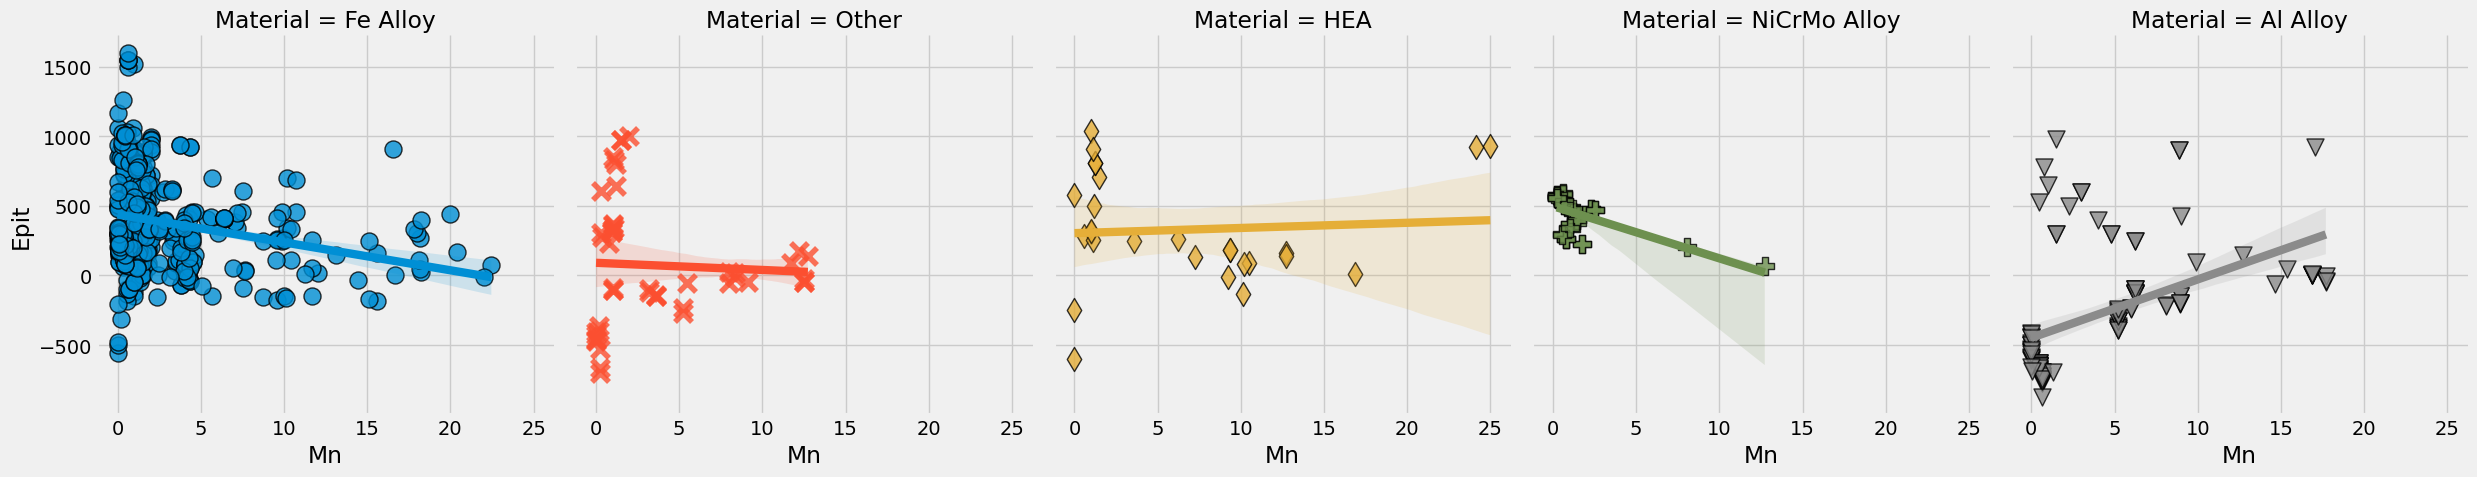

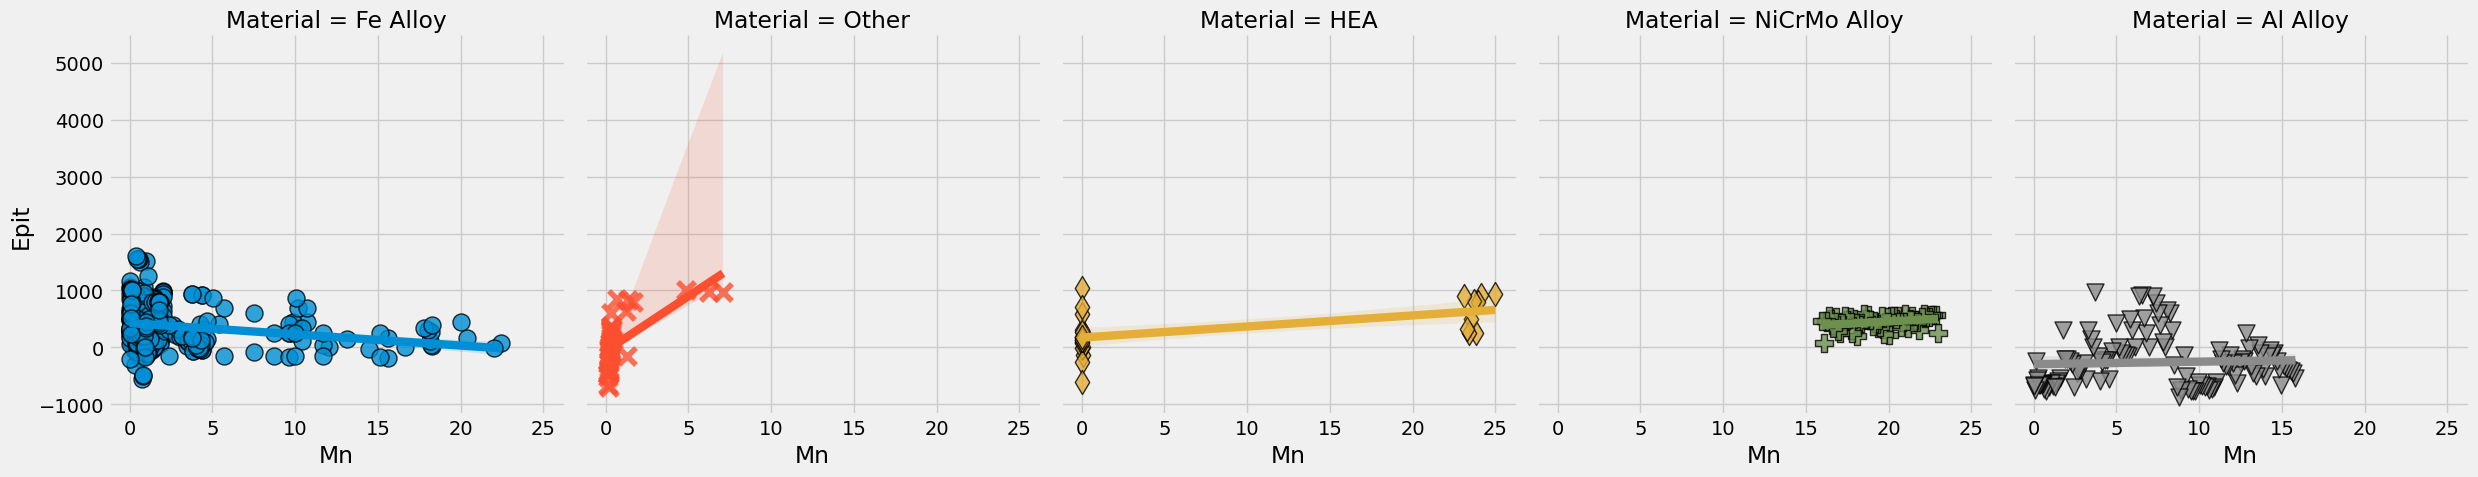

In [216]:
#sns.set_style("white")
g= sns.lmplot(x="Mn", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], col="Material", scatter_kws= {"s": 150, "edgecolor":"black"}, data= df_AlloysNan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Mn conc (ppm)");
sns.lmplot(x="Mn", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], col="Material", scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Null)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Mn conc (ppm)");
sns.lmplot(x="Mn", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], col="Material", scatter_kws= {"s": 150, "edgecolor":"black"}, data= Corr_Simputer_Ma)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Mn conc (ppm)");
sns.lmplot(x="Mn", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], col="Material", scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_NN_Ma)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Mn conc (ppm)");
sns.lmplot(x="Mn", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], col="Material", scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Inter_Ma)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Mn conc (ppm)");

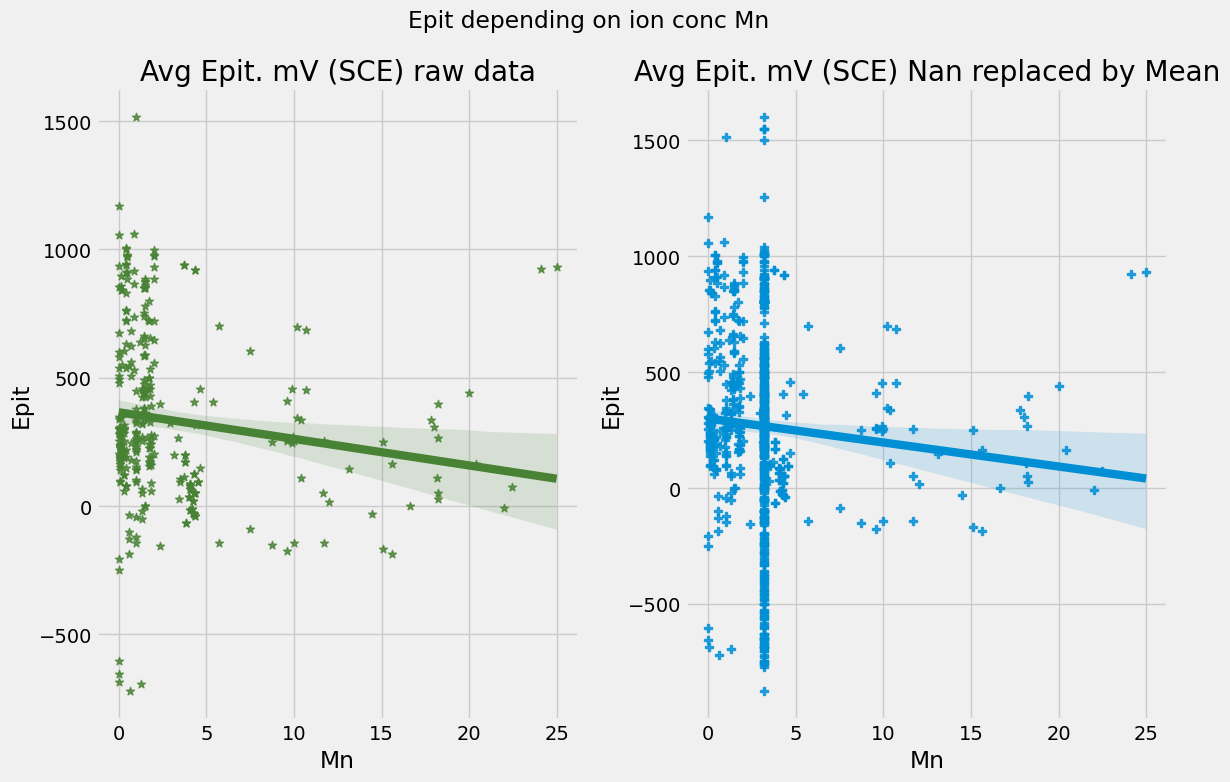

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
plt.suptitle('Epit depending on ion conc Mn')
plot1 = sns.regplot(data=Corr_Me_fnet, x='Mn', y='Epit', color="#488234", marker='*', ax=ax1)
ax1.set_title('Avg Epit. mV (SCE) raw data')
ax1.set_ylabel('Epit')
ax1.set_xlabel('Mn')

plot2 = sns.regplot(data=Corr_Simputer, x='Mn', y='Epit', marker='P', ax=ax2) #s, P, p
ax2.set_title('Avg Epit. mV (SCE) Nan replaced by Mean')
ax2.set_ylabel('Epit')
ax2.set_xlabel('Mn')
plt.tight_layout();

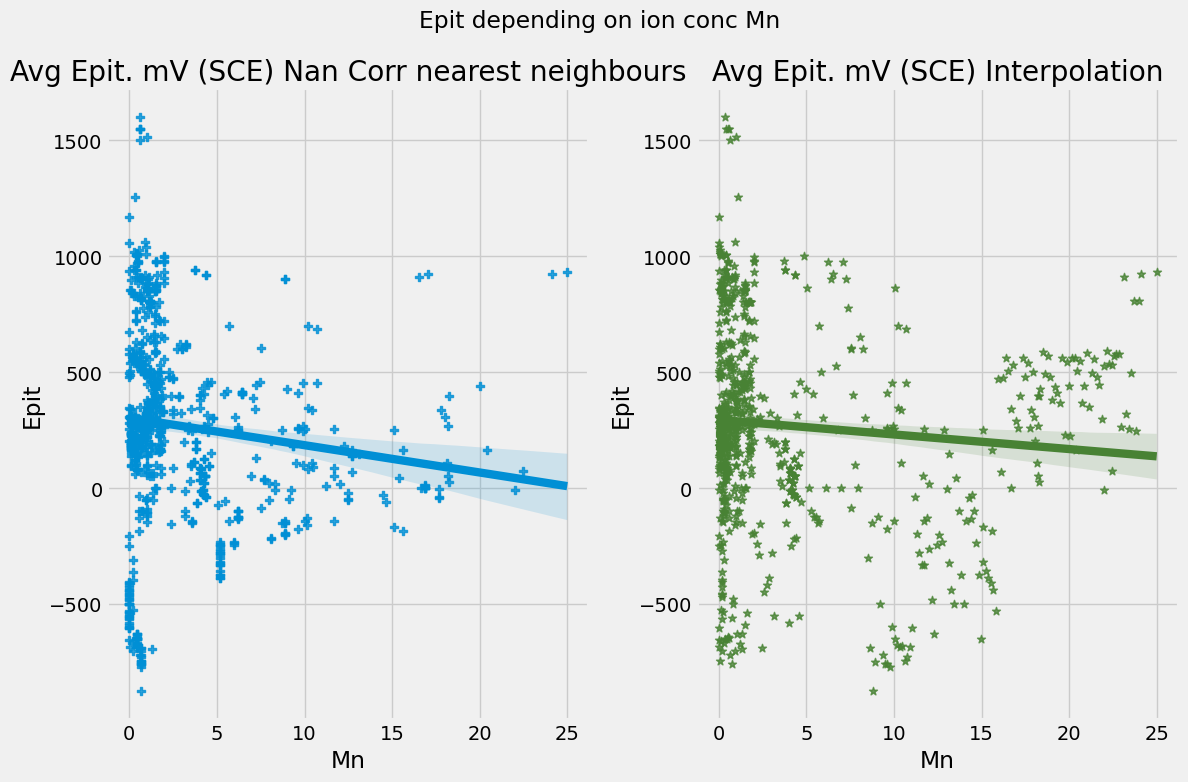

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
plt.suptitle('Epit depending on ion conc Mn')

plot1 = sns.regplot(data=Alloy_NN_Ma, x='Mn', y='Epit', marker='P', ax=ax1) #s, P, p
ax1.set_title('Avg Epit. mV (SCE) Nan Corr nearest neighbours')
ax1.set_ylabel('Epit')
ax1.set_xlabel('Mn')

plot2 = sns.regplot(data=Alloy_Inter_Ma, x='Mn', y='Epit', color="#488234", marker='*', ax=ax2)
ax2.set_title('Avg Epit. mV (SCE) Interpolation')
ax2.set_ylabel('Epit')
ax2.set_xlabel('Mn')
plt.tight_layout();

To make a better approximation on inputing the NAN values, I will have to look at the Alloy tipe column, so to know how much of the element is suppose to be on this alloy and therefore try to inpute it with a linear regression base on normal occurence of the metal by alloy

# Splitting imputing data testing 
 para que mi muestra de prueba me asegure que no estoy inputando erroneamente :smile:
I stratify by Metal Class so that my split have bifurcate content of Material Classes

In [219]:
df_AlloysNan.isna().sum()

Cl             0
Test_Temp      0
pH             0
M_Al           0
M_Fe           0
M_HEA          0
M_NiCrMo       0
M_Other        0
Fe             0
Cr             5
Ni            22
Mo            31
W             15
Nb            38
C            400
Si           411
Mn           440
Al            76
V              0
Ta             0
Re             0
Ce             0
Ti             5
Co             0
B              0
Mg             0
Y              0
Gd            12
Epit           0
Material       0
dtype: int64

In [220]:
'''
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit()
train_indices, test_indices = next(splitter.split(df_AlloysNan, df_AlloysNan.Epit, groups = df_AlloysNan.Material))
train =df_AlloysNan.iloc[train_indices]
test  =df_AlloysNan.iloc[test_indices]
'''

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\nsplitter = StratifiedShuffleSplit()\ntrain_indices, test_indices = next(splitter.split(df_AlloysNan, df_AlloysNan.Epit, groups = df_AlloysNan.Material))\ntrain =df_AlloysNan.iloc[train_indices]\ntest  =df_AlloysNan.iloc[test_indices]\n'

In [221]:
### Defining X and y
#Look for the Corr_Me column to assign it as target
y = df_AlloysNan["Epit"]
X = df_AlloysNan.drop(["Epit", "Material"], axis=1)

In [222]:
## Splitting the data for Imputating only in the Training Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# spliting original columns with nans df_AlloysNan.columns

In [223]:
X_train.shape

(608, 28)

In [224]:
# To calculate mean use imputer class
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
X1_T = imputer1.fit_transform(X_train)
X1 = pd.DataFrame(X1_T)
X1.columns= ['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
X1.shape


from sklearn.impute import KNNImputer
nan = np.nan
imputer2 = KNNImputer(n_neighbors=2, weights="uniform")

X2T=imputer2.fit_transform(X_train)
X2= pd.DataFrame(X_train)
X.columns= ['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']


#inputation with the interpolation
X3I = X_train.interpolate(method="linear")
X3= X3I.fillna(0)
#X3.isna().sum()


## Feature scaling

In [225]:
# You have to define which columns you want to scale, in this case, all the metals ions
col_scale_1 = ['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
#X1_train= X1_train.drop(col_scale) axis=1)

### Data Normalisation

In [226]:
# Scaling with MinMaxScaler
scaler_1= MinMaxScaler()
X1_train_scaled= scaler_1.fit_transform(X1[col_scale_1])
X1_train_scaled= pd.DataFrame(X1_train_scaled)
X1_train_scaled.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
X1_test_scaled= scaler_1.transform(X_test[col_scale_1])
X1_test_scaled= pd.DataFrame(X1_test_scaled)
X1_test_scaled.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']

In [227]:
X1_train_scaled.columns

Index(['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si',
       'Mn', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd'],
      dtype='object')

In [228]:
X1.drop(col_scale_1, axis=1).columns

Index(['M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other'], dtype='object')

In [229]:
#Concatenating scaled and dummy columns 
X1_train_preprocessed= np.concatenate([X1_train_scaled, X1.drop(col_scale_1, axis=1)], axis=1)#np.concatenate , pd.concat
X1_train_preprocessed= pd.DataFrame(X1_train_preprocessed)
X1_train_preprocessed.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other']

X1_test_preprocessed= np.concatenate([X1_test_scaled, X_test.drop(col_scale_1, axis=1)], axis=1)
X1_test_preprocessed= pd.DataFrame(X1_test_preprocessed)
X1_test_preprocessed.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other']

Continue in the following book, I have to bring that part to this book